# TP3 - exercice 3 : jeux de données deséquilibrés & SVMs à coûts asymétriques

Dans cet exercice nous verrons l'impact que peut avoir un déséquilibre entre classes sur l'apprentissage d'un modèle SVM, et les moyens dont on dispose pour le contrôler.

Nous travaillerons toujours à partir de la classe [**SVC**](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), et du jeu de données simulées **moon**, que l'on peut générer à partir de la fonction [make_moons](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) du module **datasets** de scikit-learn. 


Cet exercice sera également l'occasion de revoir les différents critères permettant de quantifier les peformances d'un modèle de classification (binaire), et en particulier de revoir comment construire des courbes ROC.

## Question 1.  Générer un jeu de données *moons* en introduisant un déséquilibre dans le jeu d'apprentissage avec le code ci-dessous, et le représenter. De combien d'instances d'apprentissage et de test dispose t'on pour chacune des deux catégories ?
* les objets sur lesquels nous travaillerons par la suite sont **Xtrain**, **Xtest**, **ytrain**, **ytest**.

In [3]:
# general imports #
#-----------------#
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# generate train / test datasets #
#--------------------------------#
from sklearn.datasets import make_moons
# generate dataset
X, y = make_moons(1000, noise = 0.4, random_state=27)
# split (evenly) in train test 
from sklearn.model_selection import train_test_split
Xtrain_temp, Xtest, ytrain_temp, ytest = train_test_split(X, y, test_size = 0.5, stratify = y, random_state = 27) 
# subsample class 0 in training data
ind_0 = np.argwhere(ytrain_temp == 0).ravel()
ind_1 = np.argwhere(ytrain_temp == 1).ravel()
n_sple = int(np.round(len(ind_0))/5)
ind_0_sple = ind_0[:n_sple]
ind_sple = np.concatenate( [ind_1, ind_0_sple] )
Xtrain = Xtrain_temp[ind_sple,:]
ytrain = ytrain_temp[ind_sple]

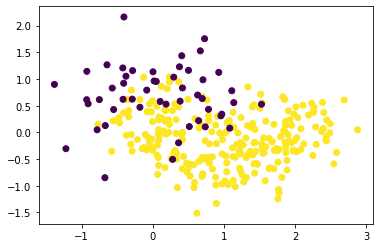

In [4]:
#Représentation
plt.scatter (Xtrain[:,0],Xtrain[:,1],c=ytrain)

## Question 2.  Optimiser les paramètres $C$ et $\gamma$ d'un classifieur SVM à noyau radial (RBF) en utilisant les données d'apprentissage et la classe *GridSearchCV*. 
* On pourra par exemple considérer les grilles de paramètres utilisées dans l'exercice prédédent.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'decision_function_shape': ['ovr', 'ovo'],
    'C':np.logspace (-3,3, num = 10)
}

svm_clf = SVC(kernel='linear')
grid_search = GridSearchCV(svm_clf,param_grid, cv = 10)
grid_search.fit(Xtrain,ytrain)

print("The best estimators are %s whith a score% 0.2f"
     % (grid_search.best_estimator_, grid_search.best_score_))

The best estimators are SVC(C=2.154434690031882, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False) whith a score 0.89


## Question 3.  Calculer (par validation croisée) la matrice de confusion correspondante et le niveau de rappel (*recall*) par classe. Qu'observez-vous ? Comment l'explique t'on ?
* pour calculer la matrice de confusion correspondante, on pourra se baser sur la fonction **cross_val_predict** qui permet de réaliser une expérience de validation croisée, et d'obtenir les prédictions individuelles (et non directement le taux de bonne classification).
* on rappelle qu'à l'issue de l'étape d'optimisation, l'objet **GridSearchCV** contient le meilleur modèle (appris sur l'ensemble du jeu d'apprentissage) dans son champ **best\_estimator\_**. Il suffit donc de le passer à la fonction **cross_val_predict**.
* on rappelle enfin qu'on peut obtenir la matrice de confusion via la fonction **confusion_matrix** du module *metrics*. La fonction **classification_report** (du même module) permet d'obtenir un petit "rapport" donnant les précisions et rappels par classe.

In [7]:
from sklearn.model_selection import cross_val_predict

cv_score = cross_val_predict(svm_clf, Xtrain,ytrain, cv=10, method='decision_function')
cv_pred=np.argmax(cv_score)
cv_pred.shape

from sklearn.metrics import accuracy_score
print('***global accuracy')
print(accuracy_score(ytest, cv_pred))

from sklearn.metrics import classification_report
print('***classification report')
print(classification_report(ytest, cv_pred))


()

## Question 4. Réaliser la même analyse en utilisant une SVM à coût asymetriques, en utilisant l'option *class_weight = 'balanced'*. Quelles sont les valeurs des coûts utilisés ? Qu'observe t'on sur le niveau de rappel par classe ?

## Question 5. Calculer (par validation croisée) les prédictions correspondantes et comparer les courbes ROC et les AUC correspondantes.
* la courbe ROC d'une SVM peut être construite en considérant le score du modèle plutôt que la prédiction 0/1. On peut l'obtenir avec la fonction **cross_val_predict** en utilisant l'option **method = 'decision_function'**.
* se référer à la documentation des fonctions [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) et [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) du package *metrics* pour la construction de ces indicateurs.

## Question 6. Une autre stratégie pour contrôler le déséquilibre consiste à utiliser une SVM standard (i.e., sans coûts asymétriques) mais à considérer un critère prenant en compte le déséquilibre des classes lors de l'optimisation du modèle. Evaluer cette stratégie en prenant comme critère l'AUC. Comparer la courbe ROC obtenue (par validation croisée) aux deux courbes ROC précédentes ainsi que les taux de rappel par classe. Que constate t'on ? Les deux stratégies sont-elles équivalentes ?
* on peut spéficier le critère de performance à considérer lors de l'optimisation des paramètres via l'argument **scoring** lors de la construction de l'objet **GridSearchCV**. Pour utiliser l'AUC, il faut spécifier **scoring = 'roc_auc'**.

## Question 7. Enfin, confirmer ces observations en évaluant les 3 modèles sur le jeu de test (qui ne souffre pas de déséquilibre).
* on considèrera là aussi les courbes ROC et le taux de rappel par classe.